In [6]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
imNum = 1   # счётчик для названий картинок
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}'
})
plt.rcParams.update({
    "figure.figsize": (8, 5),
    'figure.dpi': 200

})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

In [2]:
#ВВод данных
df = pd.read_excel("conducting.ods", engine="odf") # для таблиц ods (требуется установка pip install odfpy)
# df = pd.read_excel("measurements.xls")    # excel таблицы
df.iloc[:10, 0].dropna()
df.head()

,"Vэ, мВ","Vн, мВ","Q, мВт","R, $\Omega$",23C,"Vэ, мВ.1","Vн, мВ.1","Q, мВт.1","R, $\Omega$.1",33C,"Vэ, мВ.2","Vн, мВ.2","Q, мВт.2","R, $\Omega$.2",45C,"Vэ, мВ.3","Vн, мВ.3","Q, мВт.3","R, $\Omega$.3",60C
0,1.219,2.04,0.000249,16.735029,NaN,0.60,1.01,0.000061,16.833333,NaN,76.6,137.0,1.04942,17.885117,NaN,76.5,150.0,1.147500,19.607843,NaN
1,162.620,273.40,4.446031,16.812200,NaN,15.59,26.88,0.041906,17.241822,NaN,350.3,670.0,23.47010,19.126463,NaN,343.5,763.0,26.209050,22.212518,NaN
2,239.540,403.70,9.670230,16.853135,NaN,70.18,121.50,0.852687,17.312625,NaN,480.6,945.0,45.41670,19.662921,NaN,470.3,1032.0,48.534960,21.943440,NaN
3,339.950,575.42,19.561403,16.926607,NaN,286.35,504.70,14.452084,17.625284,NaN,577.5,1137.0,65.66175,19.688312,NaN,566.4,1212.8,68.692992,21.412429,NaN
4,439.060,747.75,32.830711,17.030702,NaN,369.60,659.80,24.386208,17.851732,NaN,670.1,1281.0,85.83981,19.116550,NaN,655.5,1358.5,89.049675,20.724638,NaN


In [3]:
# параметры построения графика и аппроксмации
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = True   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{\Omega}{мВт}$
b, $\Omega$
'''
xi = 2
yi = 3
labeli = 4
stride = 5
xname, xunit = r"$Q$", "мВт"
yname, yunit = r"$R$", r"$\Omega$"
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

6.954392715621475 +- 0.0034431767255997166
-95.2437937382015 +- 0.07142147701534404


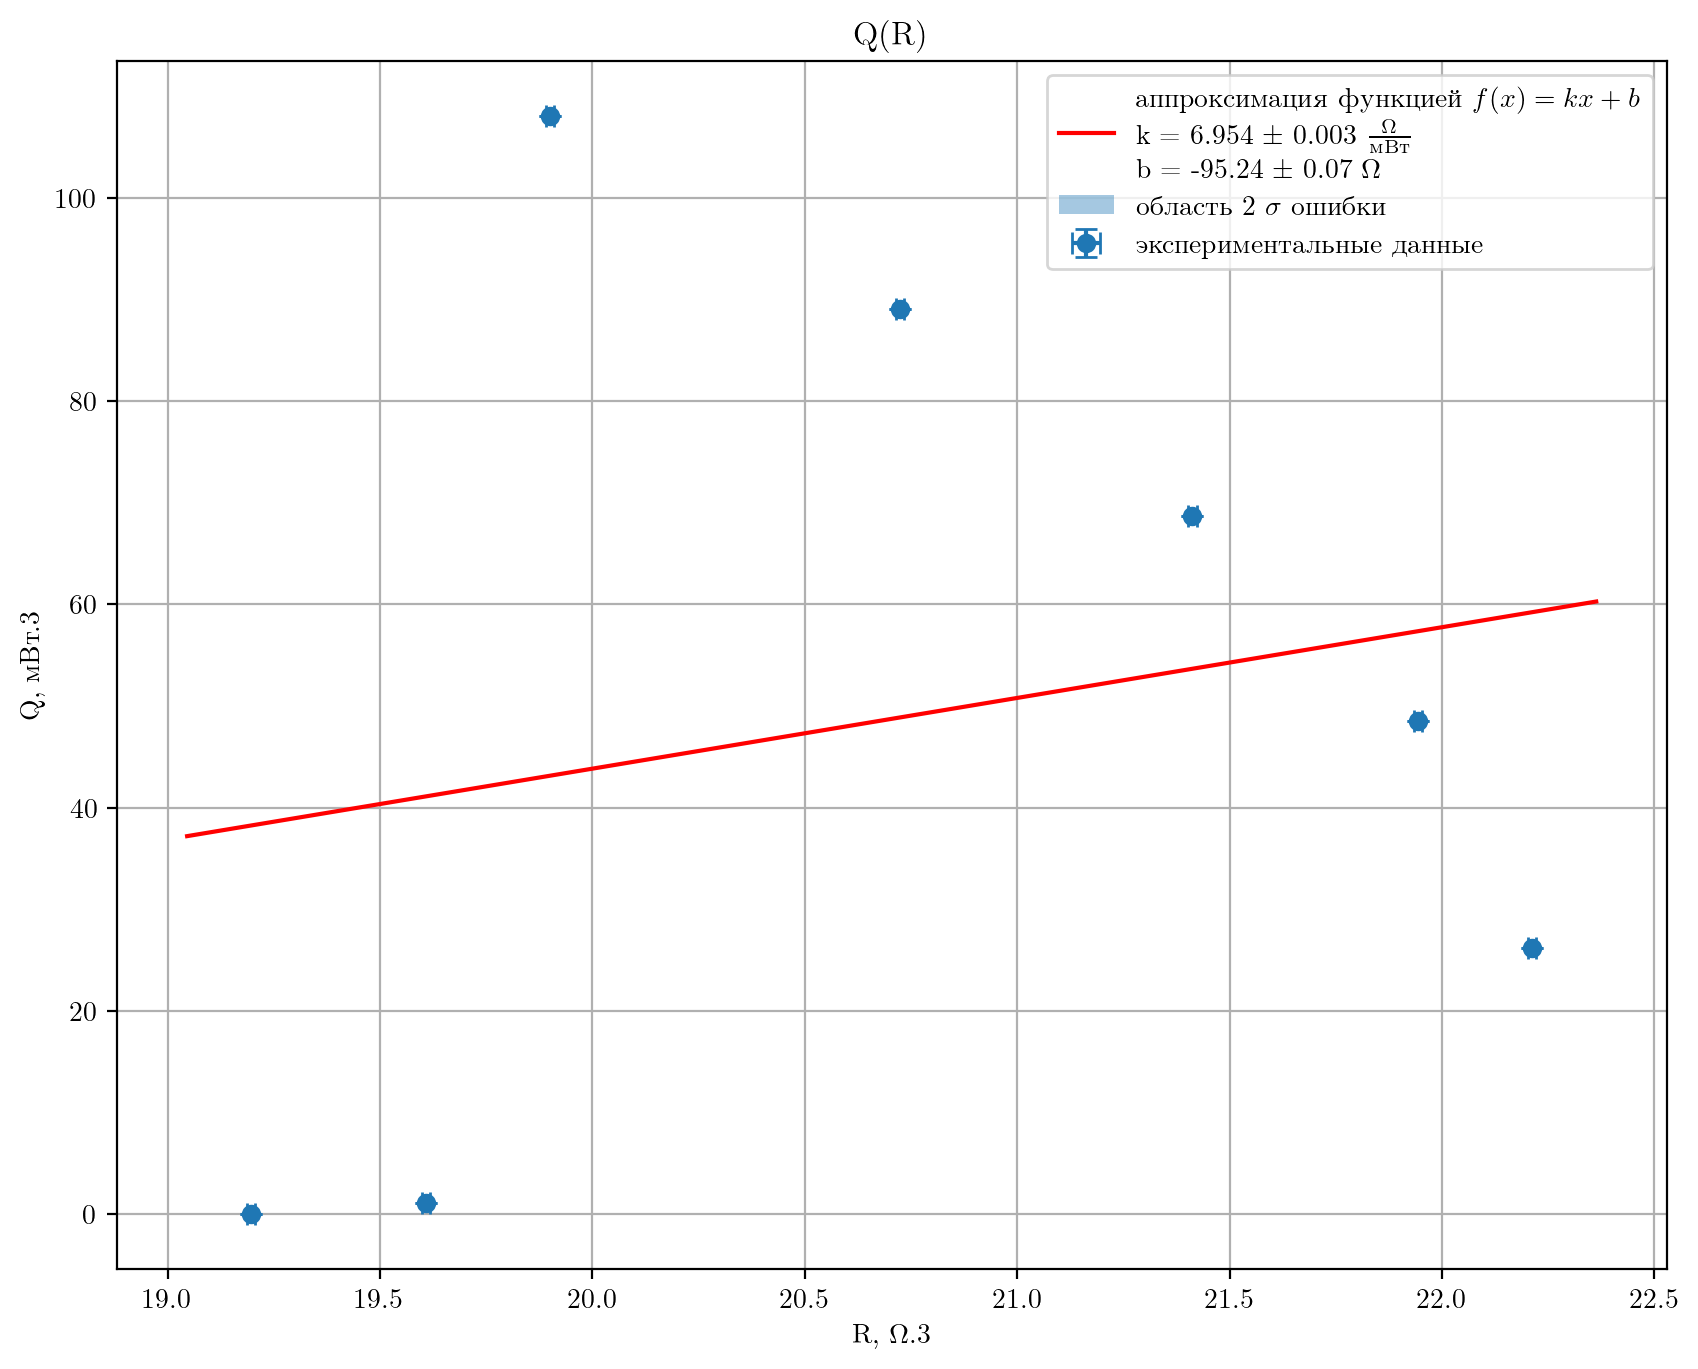

In [7]:
# построение графика

# опциональная загрузка данных разных измерений
N = 3 # номер измерения
stride = 5
x = df.iloc[:, stride*N+3].dropna()
y = df.iloc[:, stride*N+2].dropna()
xerr = np.ones_like(x)*0.01
yerr = np.ones_like(x)*0.01

xname, xunit = x.name.split(', ')
yname, yunit = y.name.split(', ')

if hasErrors:
    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
else:
    popt, pcov = curve_fit(f, x, y)

err = np.sqrt(np.diag(pcov))
for v, er in zip(popt, err):
    print(v,'+-',er)

approx_label = f"аппроксимация функцией {fun_name}"
par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
for i in range(len(par_names)):
    name, units = par_names[i]
    tup = err_pres_formatter(popt[i], err[i])
    approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"
    

plt.figure(figsize=(10, 8))
if hasErrors:
    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label="экспериментальные данные", capsize=4, ms=6)
else:
    plt.plot(x, y, "o", label="экспериментальные данные")
teorPoints = 50     
intent = 0.05   # отступ по бокам от обласи экспериментальных данных
a, b = x.min(), x.max()
X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
plt.plot(X, f(X, *popt), 'r', label=approx_label)
if visApproxError:
    nsigma = 2
    minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

0.007399683801827412 	 0.00019067943920742203	16.77088871579943 	 0.009809636105584297	
0.021405492423989675 	 0.001107440338848851	17.285792689569664 	 0.026386990988002512	
0.007479538180271023 	 0.007498055750749432	18.66048101265877 	 0.48979705360924397	
0.00549212532522343 	 0.012325349690625995	20.445774028892217 	 0.770513779672169	


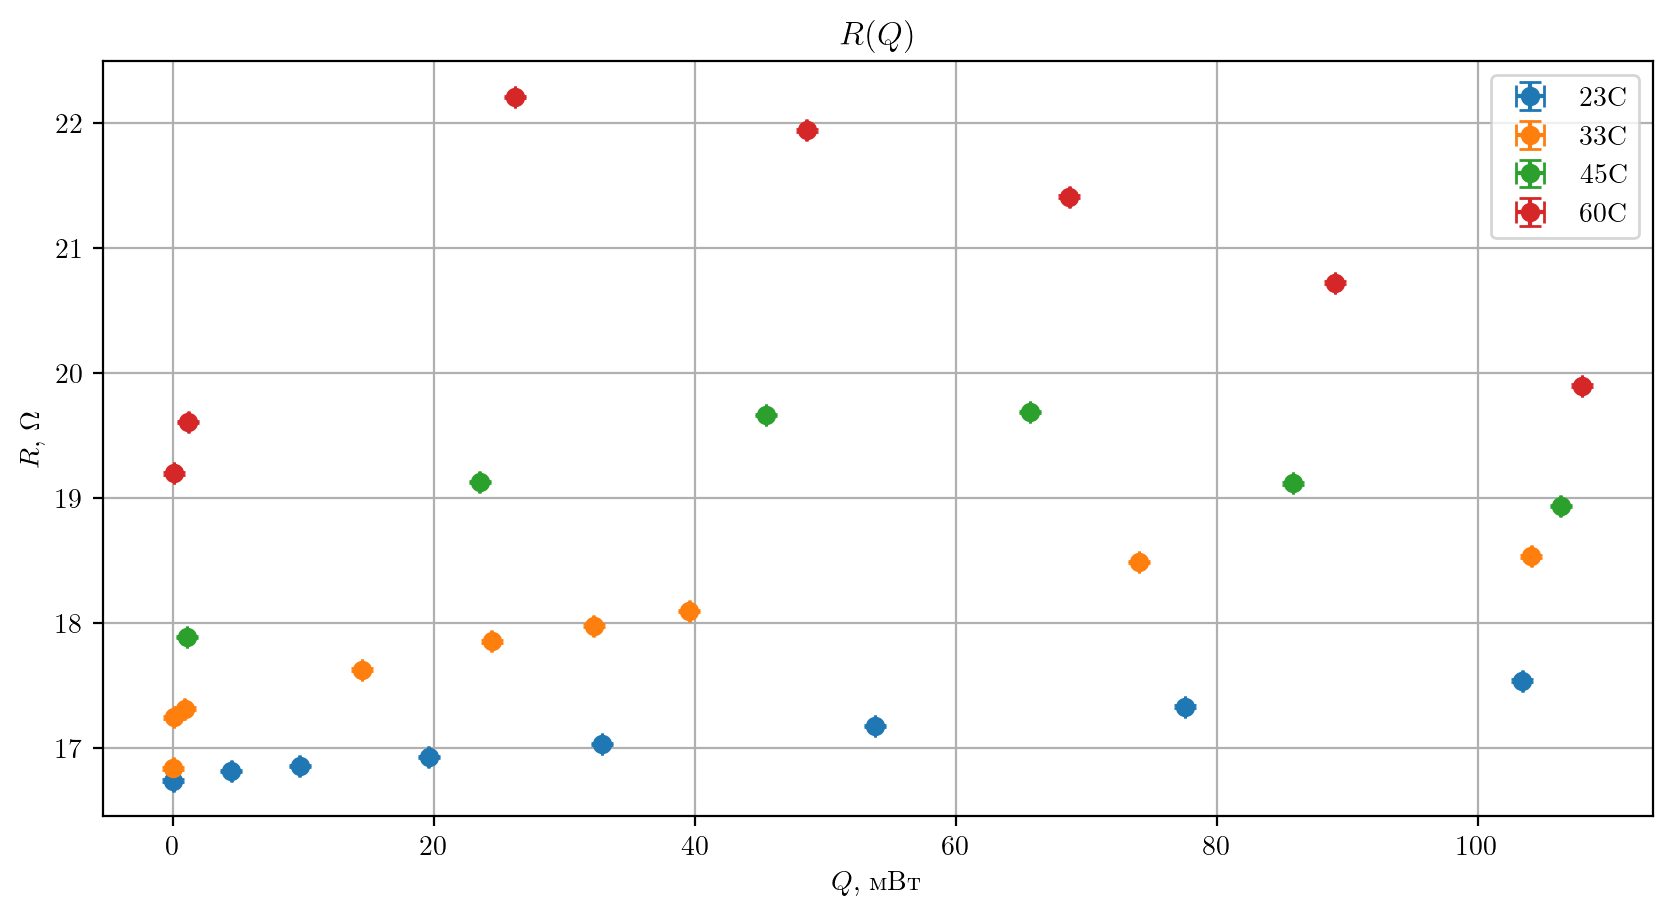

In [5]:
#Несколько графиков на одном холсте
df = pd.read_excel("conducting.ods", engine="odf")
def make_graph(N):
    size = 170
    x = df.iloc[:, stride*N+xi].dropna()[:size]
    y = df.iloc[:, stride*N+yi].dropna()[:size]
    label = df.iloc[:, stride*N+labeli].name
    xerr = np.ones_like(x)*0.01
    yerr = np.ones_like(x)*0.01

    if N == 1:
        popt, pcov = curve_fit(f, x[1:-2], y[1:-2], sigma=yerr[1:-2], absolute_sigma=False)
        # print(x[1:-2])
    else:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=False)

    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'\t',er, end='\t')
    print()

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    # teorPoints = 50     
    # intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    # a, b = x.min(), x.max()
    # X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    # plt.plot(X, f(X, *popt), 'r', label=approx_label)
    # if visApproxError:
    #     nsigma = 2
    #     minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
    #     plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
make_graph(1)
make_graph(2)
make_graph(3)
# make_graph(4)

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")

# handles, labels = plt.gca().get_legend_handles_labels()
# n = len(handles)//2
# order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [11]:
imNum

3

## Данные Никиты

In [25]:
# параметры построения графика и аппроксмации
# пользовательские параметры. Переменные x, y, xerr, yerr дожны содержать данные
''' также необходимо изменить
название осей с размерностями, 
название графика, 
название функции ,
набор параметров с размерностями через запятую '''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{\Omega}{мВт}$
b, $\Omega$
'''
xi = 2
yi = 3
labeli = 4
xname, xunit = r"$Q$", "мВт"
yname, yunit = r"$R$", r"$\Omega$"
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров

0.0035116570281557204 	 6.991146103539495e-06	14.692498616722798 	 0.0004867806165235077	
0.004305851434195579 	 0.0003615045050720745	14.961275090393887 	 0.009137412458280817	
0.0050274458711171725 	 0.00020103689141127528	15.136974003022468 	 0.008489053331787646	
0.009248288055640711 	 0.0003338144959204897	15.337639170223033 	 0.008387003071594887	


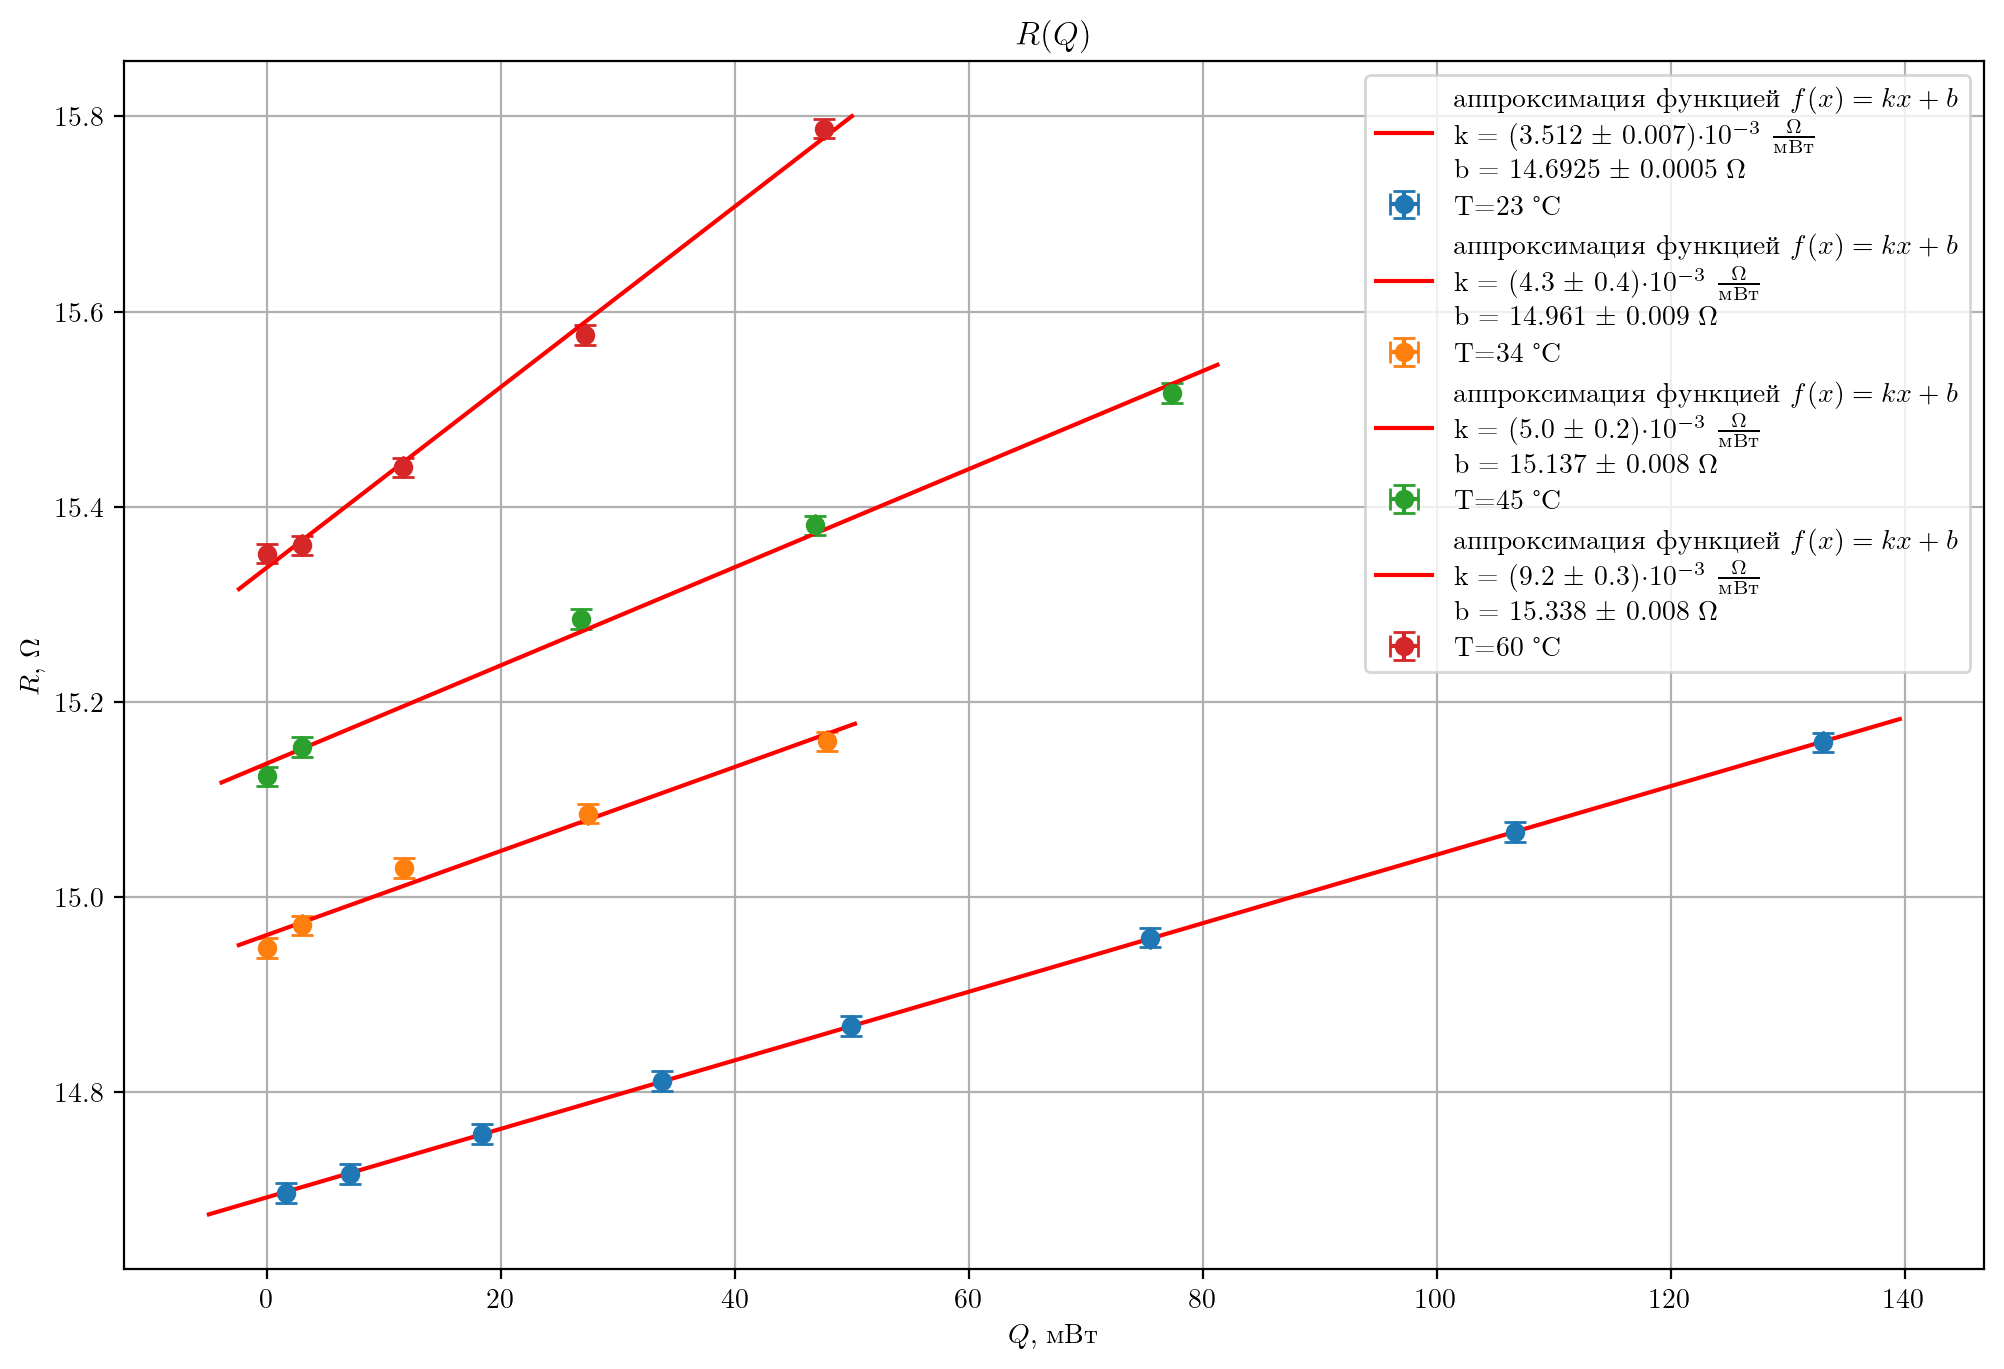

In [26]:
#Несколько графиков на одном холсте
df = pd.read_excel("Nik_data.xlsx", sheet_name=1)
stride = 6
labeli = 0
xi = 3
yi = 4
def make_graph(N):
    size = 170
    x = df.iloc[:, stride*N+xi].dropna()[:size]
    y = df.iloc[:, stride*N+yi].dropna()[:size]
    label = df.iloc[:, stride*N+labeli].name
    xerr = np.ones_like(x)*0.01
    yerr = np.ones_like(x)*0.01

    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=False)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'\t',er, end='\t')
    print()
    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        tup = err_pres_formatter(popt[i], err[i])
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 1
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
make_graph(1)
make_graph(2)
make_graph(3)
# make_graph(4)

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type
# plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

# Сводные данные

In [38]:
# параметры построения графика и аппроксмации
# пользовательские параметры.
'''необходимо изменить:
название графика, 
название функции,
набор параметров с размерностями через запятую, 
указать расположение колонок с данными (stride, ...)'''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, $\frac{\Omega}{^{o}C}$
b, $\Omega$
'''
xname, xunit = r"$T$", r"$^{o}C$"
yname, yunit = r"$R$", r"$\Omega$"
stride = 8
xi = 0
yi = 3
labeli = stride-1
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
from scipy.optimize import curve_fit

0.01846971008304042 +- 0.00019100566232505578
14.267876371769466 +- 0.004462683228268979
0.046809452160936536 +- 0.0025592183468266735
15.69427131609786 +- 0.06295535971416054


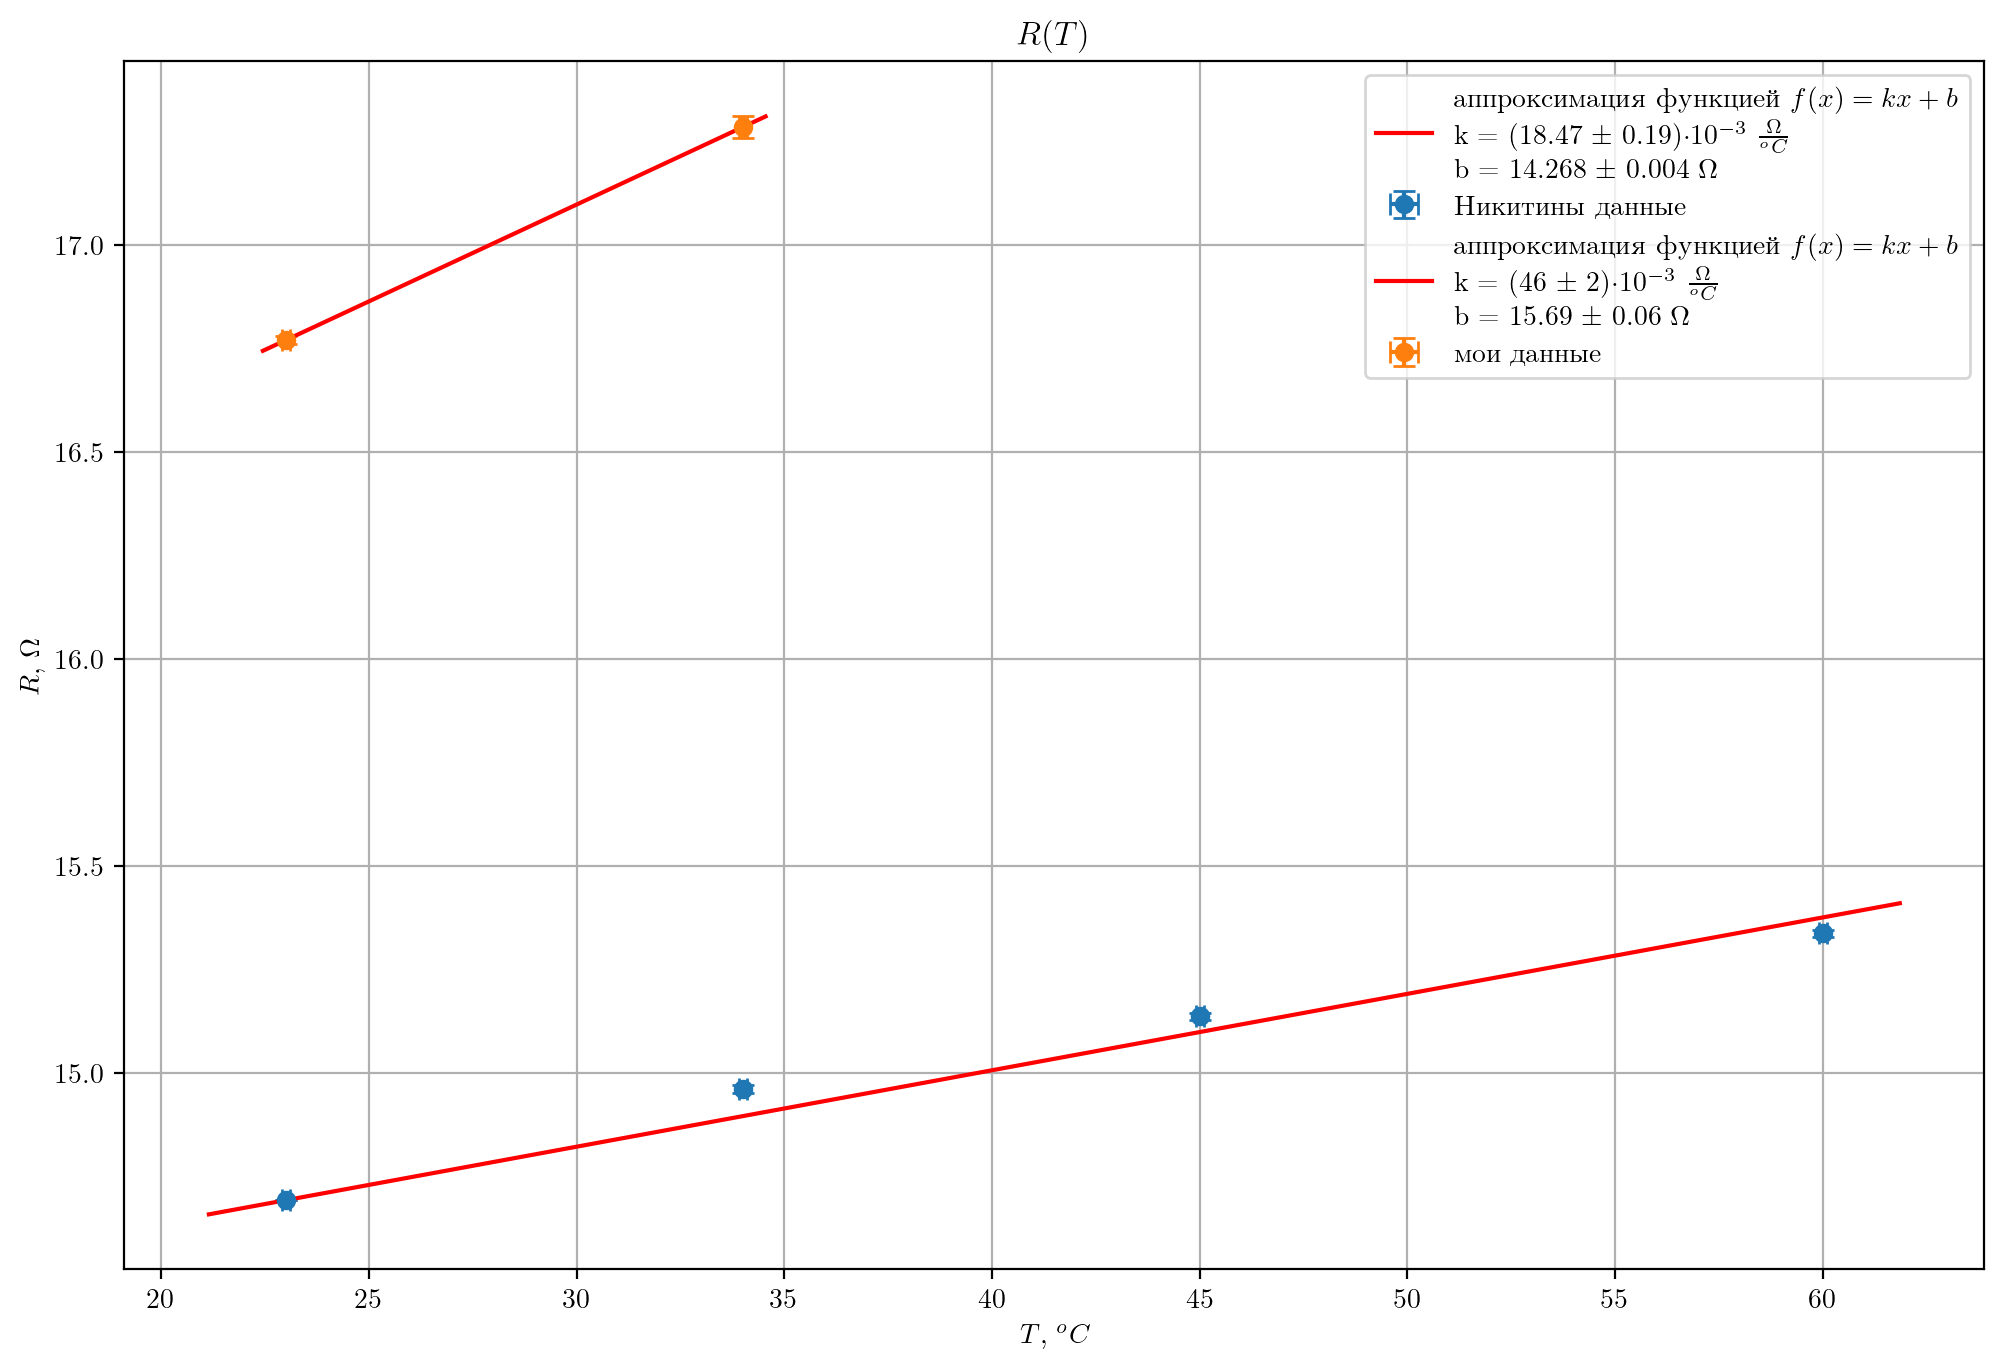

In [39]:
#Несколько графиков на одном холсте
df = pd.read_excel("pivot_table.ods", engine="odf")
def make_graph(N):
    size = 170
    x = df.iloc[:, stride*N+xi].dropna()[:size]
    y = df.iloc[:, stride*N+yi].dropna()[:size]
    label = df.iloc[:, stride*N+labeli].name
    xerr = np.ones_like(x)*0.1
    yerr = df.iloc[:, stride*N+4].dropna()

    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=fr"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
make_graph(1)
# # make_graph(2)
# # make_graph(3)
# make_graph(4)

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type


if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [8]:
# final graph
# параметры построения графика и аппроксмации
# пользовательские параметры.
'''необходимо изменить:
название графика, 
название функции,
набор параметров с размерностями через запятую, 
указать расположение колонок с данными (stride, ...)'''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
# par_names_str = r'''
# k, $\frac{\Omega}{^{o}C}$
# b, $\Omega$
# '''
xname, xunit = r"$T$", r"$^{o}C$"
yname, yunit = r"$\kappa$", r"$\frac{Вт}{м\cdot ^oC}$"
stride = 8
xi = 0
yi = 3
labeli = stride-1
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
from scipy.optimize import curve_fit

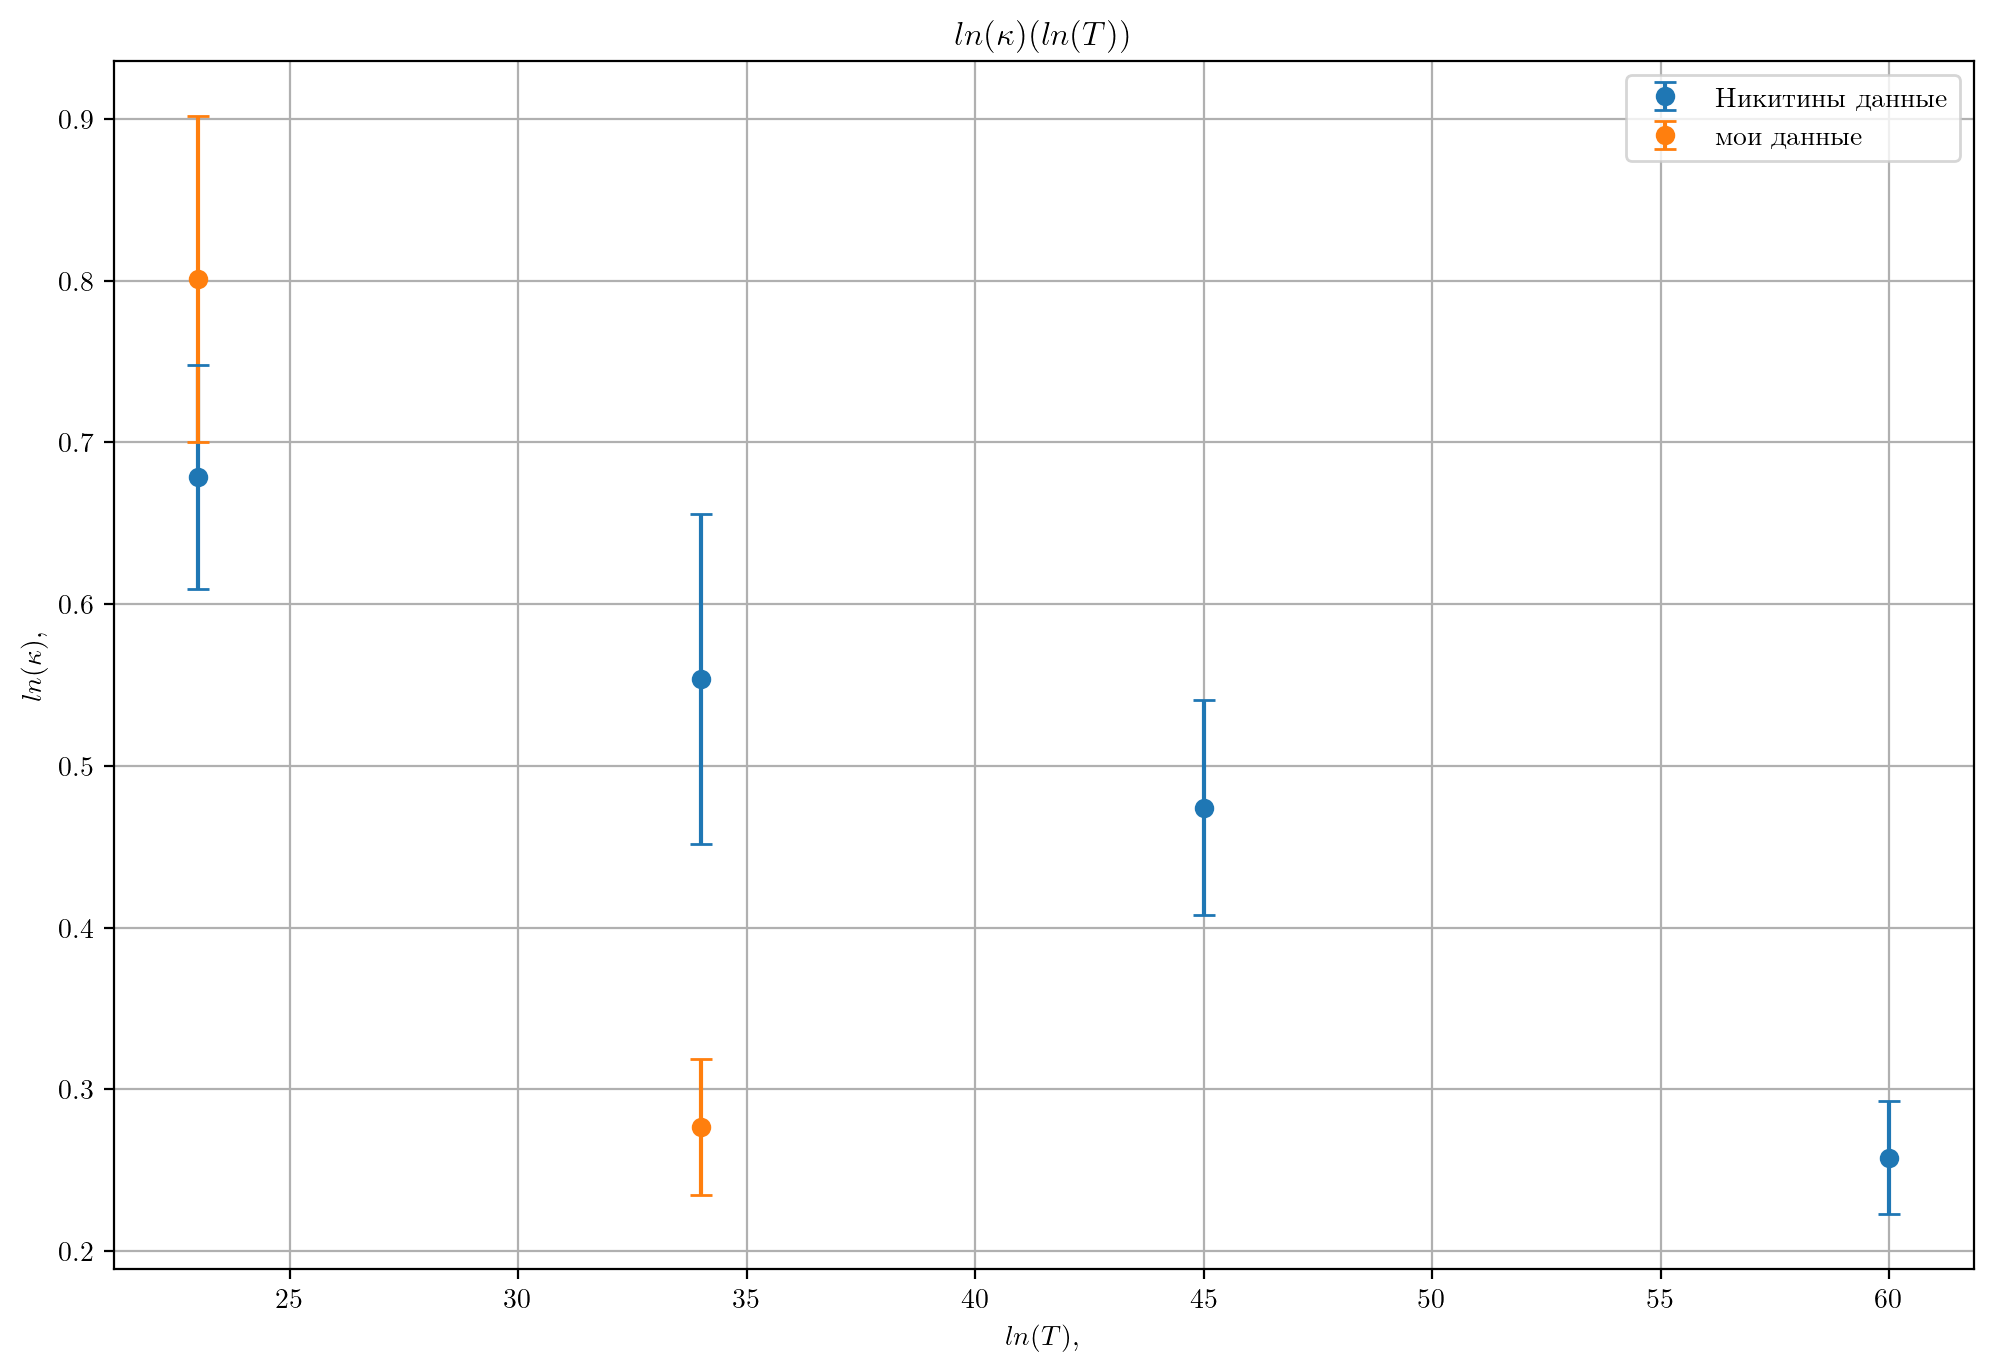

In [23]:
#Несколько графиков на одном холсте
df = pd.read_excel("pivot_table.ods", engine="odf")
def make_graph(N):
    size = 170
    k = df.iloc[:, stride*N+1].dropna()
    dk = df.iloc[:, stride*N+2].dropna()
    if N == 0:
        y = np.log(20)*18.5e-3/2/np.pi/3.7/k
    else:
        y = np.log(20)*46e-3/2/np.pi/3.7/k
    ey = 0.1 + dk/k

    x = df.iloc[:, stride*N+xi].dropna()
    # y = df.iloc[:, stride*N+yi].dropna()
    label = df.iloc[:, stride*N+labeli].name
    xerr = None
    yerr = y*ey

    # popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
    # err = np.sqrt(np.diag(pcov))
    # for v, er in zip(popt, err):
    #     print(v,'+-',er)

    # approx_label = f"аппроксимация функцией {fun_name}"
    # par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    # for i in range(len(par_names)):
    #     name, units = par_names[i]
    #     approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    # teorPoints = 50     
    # intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    # a, b = x.min(), x.max()
    # X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    # plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=fr"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
make_graph(1)

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")

# handles, labels = plt.gca().get_legend_handles_labels()
# n = len(handles)//2
# order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
# plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type
plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1

In [20]:
# final graph log axis
# параметры построения графика и аппроксмации
# пользовательские параметры.
'''необходимо изменить:
название графика, 
название функции,
набор параметров с размерностями через запятую, 
указать расположение колонок с данными (stride, ...)'''
visApproxError = False   # рисовать ли область ошибки аппроксимации
hasErrors = True
# visApproxError*=hasErrors   # нельзя рисовать ошибки, если их нет)
par_names_str = r'''
k, .
b, .
'''
xname, xunit = r"$ln(T)$", r""
yname, yunit = r"$ln(\kappa)$", r""
stride = 8
xi = 0
yi = 3
labeli = stride-1
# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return b + k * x
# конец пользовательских параметров
from scipy.optimize import curve_fit

-7.748147882449152 +- 1.3908138648260957
43.74295645011979 +- 7.98139389875078
-29.110988199681174 +- 5.401262419660318
165.43016986775203 +- 30.815536154280508


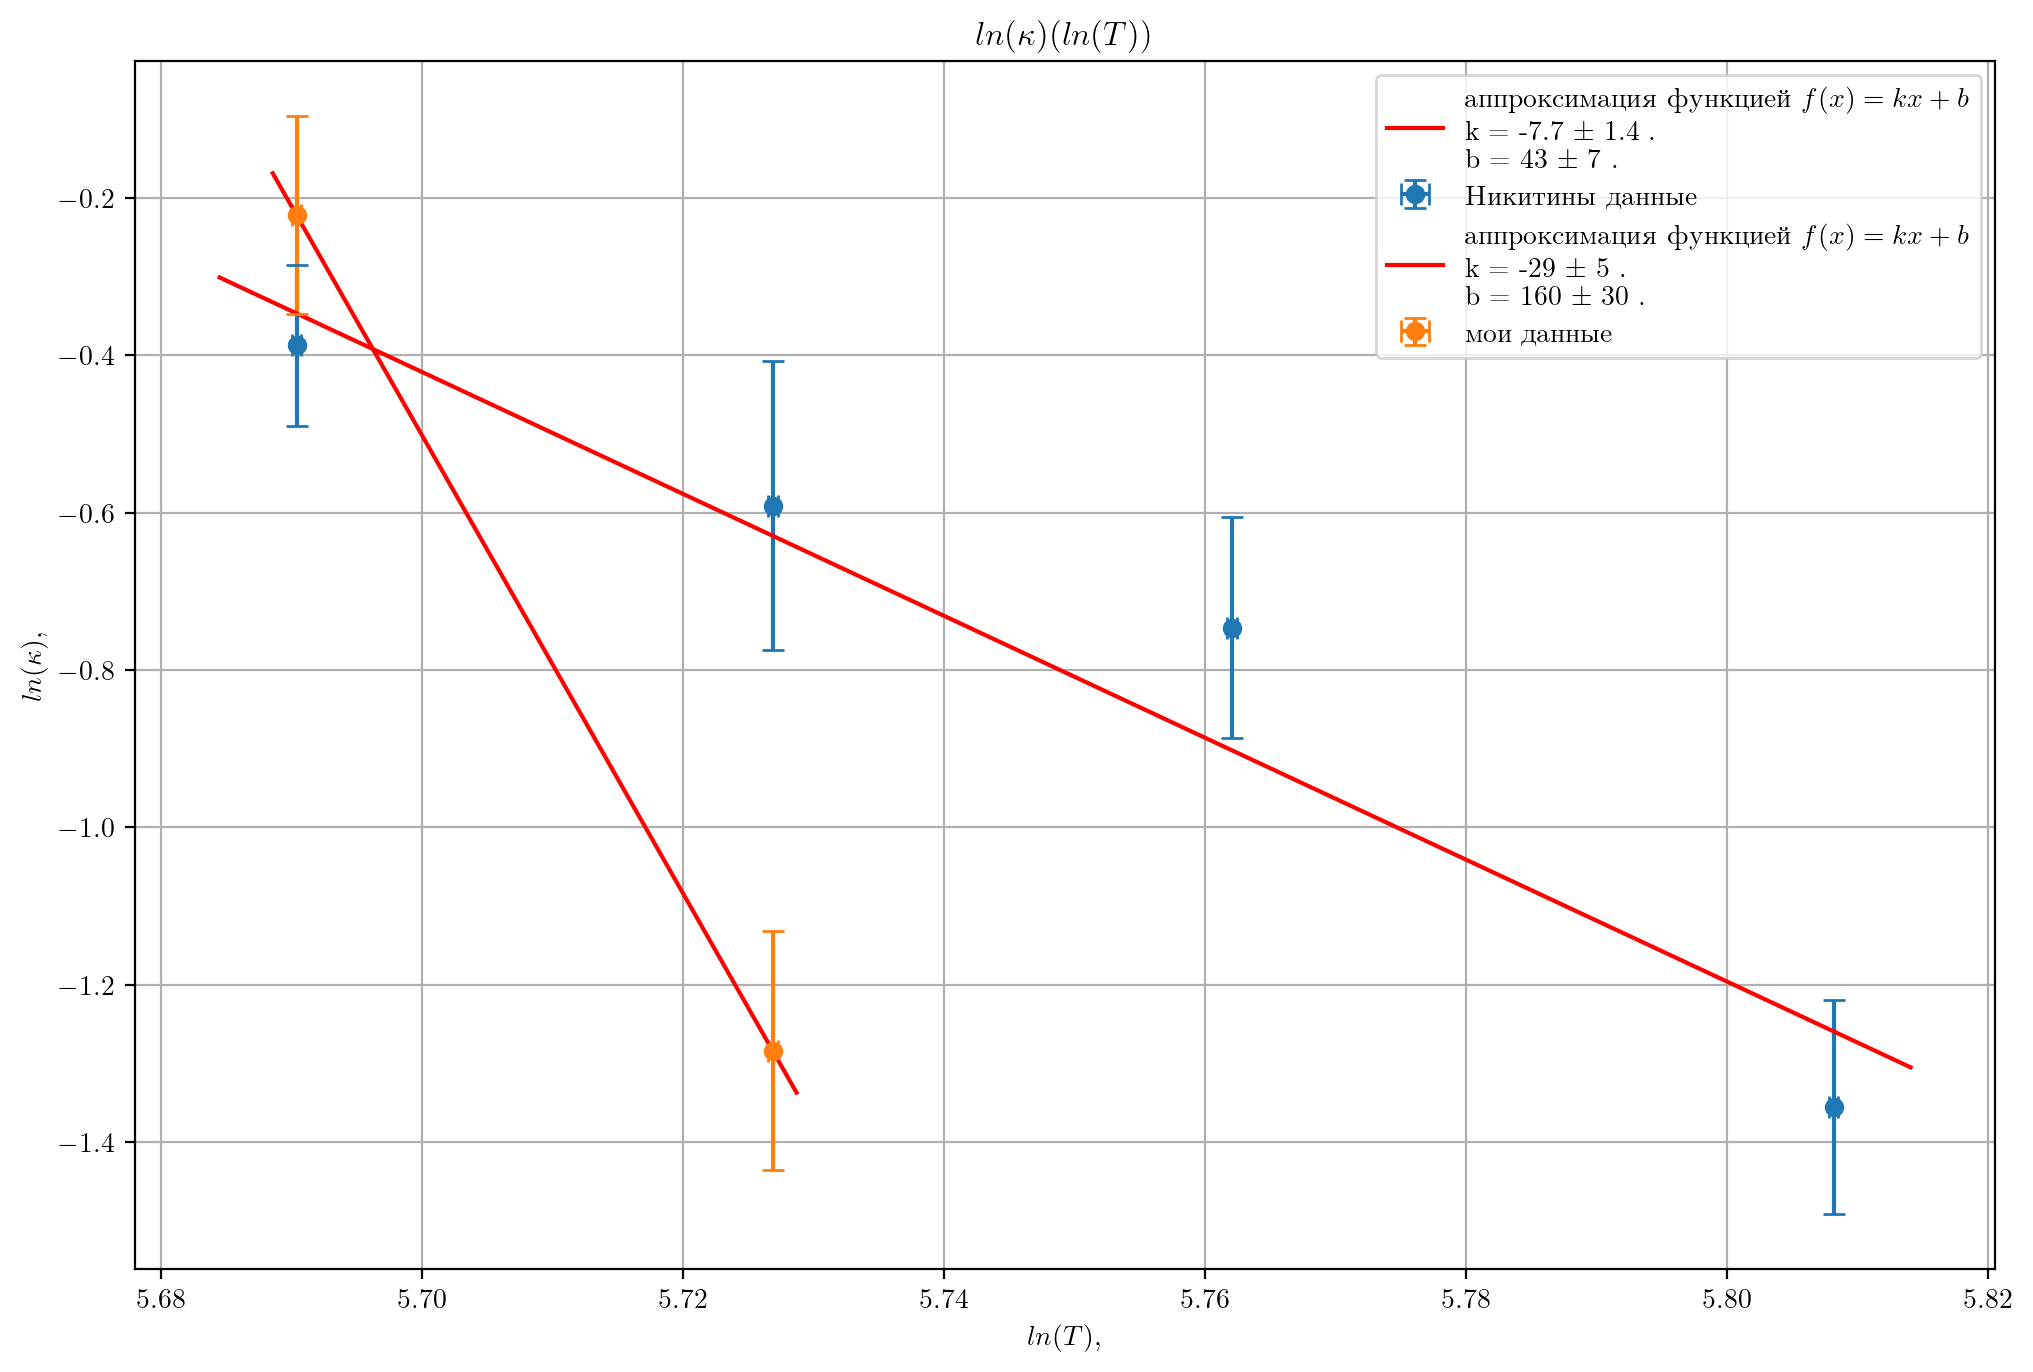

In [24]:
#Несколько графиков на одном холсте
df = pd.read_excel("pivot_table.ods", engine="odf")
def make_graph(N):
    size = 170
    k = df.iloc[:, stride*N+1].dropna()
    dk = df.iloc[:, stride*N+2].dropna()
    if N == 0:
        y = np.log(np.log(20)*18.5e-3/2/np.pi/3.7/k)
    else:
        y = np.log(np.log(20)*46e-3/2/np.pi/3.7/k)
    ey = 0.1 + dk/k

    x = np.log(df.iloc[:, stride*N+xi].dropna() + 273)
    # y = df.iloc[:, stride*N+yi].dropna()
    label = df.iloc[:, stride*N+labeli].name
    xerr = np.ones_like(x)*0.1/273
    yerr = ey

    popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)

    approx_label = f"аппроксимация функцией {fun_name}"
    par_names = [x.split(', ') for x in par_names_str.strip().split("\n")]
    for i in range(len(par_names)):
        name, units = par_names[i]
        approx_label += f"\n{name} = {err_pres_formatter(popt[i], err[i])} {units}"

    plt.errorbar(x, y, fmt="o", xerr=xerr, yerr=yerr, label=label, capsize=4, ms=6)
    teorPoints = 50     
    intent = 0.05   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError:
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=fr"облсть {nsigma} $\sigma$ ошибки")

make_graph(0)
make_graph(1)

plt.grid(True)
plt.xlabel(fr"{xname}, {xunit}")
plt.ylabel(fr"{yname}, {yunit}")
plt.title(fr"{yname}({xname})")

handles, labels = plt.gca().get_legend_handles_labels()
n = len(handles)//2
order = [i//2 if i%2==0 else n + i//2 for i in range(2*n)]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])  # labels grouped by source, not by type
# plt.legend()

if not os.path.exists(impath):
    os.makedirs(impath)
plt.savefig(os.path.join(impath, f"templ{imNum}.png"), dpi=300)
imNum+=1